imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
!pip install pymannkendall
import pymannkendall as mk
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from scipy.stats import chi2_contingency, kruskal
from statsmodels.tsa.stattools import ccf
import warnings
warnings.filterwarnings('ignore')

initialization

In [ ]:
# Create output directory for plots
output_dir = "statistical_test_results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the dataset
df = pd.read_csv("Egypt_terr_augmented_with_infilation.csv")
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")

# Basic data preparation
# Get the name of the last column which contains inflation data
last_column = df.columns[-1]

# Convert date components to datetime
df['date'] = pd.to_datetime({'year': df['iyear'],
                            'month': df['imonth'],
                            'day': df['iday']}, errors='coerce')

# Extract inflation data from the last column in the same dataset
# Create a dataframe with unique years and their corresponding inflation values
inflation_data = df[['iyear', last_column]].drop_duplicates().reset_index(drop=True)
print(f"Inflation data extracted with {inflation_data.shape[0]} unique year entries")

# Create yearly aggregation for time series analysis
yearly_counts = df.groupby('iyear').size().reset_index(name='incident_count')
yearly_counts = pd.merge(yearly_counts, inflation_data, on='iyear', how='left')

# Create regional aggregation
region_counts = df.groupby('provstate').size().reset_index(name='incident_count')
region_counts = region_counts.sort_values('incident_count', ascending=False)

# Calculate fatalities by region
region_fatalities = df.groupby('provstate')['nkill'].agg(['sum', 'mean', 'count']).reset_index()
region_fatalities = region_fatalities.sort_values('sum', ascending=False)


Dataset loaded with 2478 rows and 46 columns
Inflation data extracted with 36 unique year entries


# Hypothesis Test 1

In [ ]:
# Display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
#----------------------------------------------------#

# Load the dataset
#df = pd.read_csv('Egypt_terr_augmented_with_infilation.csv')
df = pd.read_csv("Egypt_terr_augmented_with_infilation.csv")
# Display the first few rows of the dataset
df.head()

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,target1,natlty1,natlty1_txt,gname,guncertain1,individual,weaptype1,weaptype1_txt,nkill,property,ishostkid,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,date,inflation_rate
0,197003140002,1970,3,14,0,60,Egypt,10,Middle East & North Africa,Alexandria,Alexandria,31.198056,29.919167,1.0,0,1,1,1,0.0,0.0,1,0,3,Bombing/Explosion,6,Airports & Aircraft,42.0,Aircraft (not at an airport),United Arab Airlines Flight Antonov 24 Acft,60.0,Egypt,Unknown,0.0,0,6,Explosives,0.0,1,0.0,PGIS,-9,-9,0,-9,1970-03-14,3.76
1,197111280001,1971,11,28,0,60,Egypt,10,Middle East & North Africa,Cairo,Cairo,30.084629,31.334314,1.0,0,1,1,1,0.0,0.0,1,0,1,Assassination,2,Government (General),17.0,Head of State,"Jordanian Prime Minister, Wasfi Tal",60.0,Egypt,Black September,0.0,0,5,Firearms,1.0,0,0.0,PGIS,1,1,0,1,1971-11-28,3.14
2,197202190001,1972,2,19,0,60,Egypt,10,Middle East & North Africa,Cairo,Cairo,30.084629,31.334314,1.0,0,1,1,1,0.0,0.0,0,0,4,Hijacking,6,Airports & Aircraft,42.0,Aircraft (not at an airport),Caravelle,102.0,Jordan,Jordanian National Liberation Movement,0.0,0,6,Explosives,0.0,0,1.0,Hijacking DB,0,1,1,1,1972-02-19,2.10
3,197712050001,1977,12,5,0,60,Egypt,10,Middle East & North Africa,Cairo,Cairo,30.084629,31.334314,1.0,0,1,1,1,0.0,0.0,1,0,1,Assassination,10,Journalists & Media,53.0,Newspaper Journalist/Staff/Facility,"David Holden, Chief of Foreign Correspondents",216.0,Great Britain,Unknown,0.0,0,5,Firearms,1.0,0,0.0,PGIS,-9,-9,1,1,1977-12-05,12.73
4,197809300002,1978,9,30,0,60,Egypt,10,Middle East & North Africa,North Sinai,Yamit,31.275278,34.167778,1.0,1,1,1,1,-9.0,0.0,1,0,3,Bombing/Explosion,14,Private Citizens & Property,79.0,"Public Area (garden, parking lot, garage, beac...",beach at yamit,97.0,Israel,Palestinians,0.0,0,6,Explosives,0.0,1,0.0,PGIS,1,0,1,1,1978-09-30,11.08


In [ ]:
df['date'] = pd.to_datetime(df['date'])
#----------------------------------------------------#
#monthly time series of attacks and fatalities
df['month'] = df['date'].dt.to_period('M')
monthly_df = df.groupby('month').agg({
    'eventid': 'count',
    'nkill': 'sum'
}).rename(columns={'eventid': 'attacks'}).reset_index()
#----------------------------------------------------#
# 🔄 Convert month back to datetime
monthly_df['month'] = monthly_df['month'].dt.to_timestamp()

# 🗓️ Define key interruption dates
arab_spring = pd.to_datetime('2011-01-01')
sisi_presidency = pd.to_datetime('2014-06-01')
#----------------------------------------------------#
# time and intervention variables
monthly_df['time'] = np.arange(len(monthly_df))
monthly_df['post_arab_spring'] = (monthly_df['month'] >= arab_spring).astype(int)
monthly_df['post_sisi'] = (monthly_df['month'] >= sisi_presidency).astype(int)
monthly_df['time_post_arab_spring'] = monthly_df['time'] * monthly_df['post_arab_spring']
monthly_df['time_post_sisi'] = monthly_df['time'] * monthly_df['post_sisi']
#----------------------------------------------------#
# 📊 Define ITSA model function
def fit_itsa_model(outcome):
    X = monthly_df[[
        'time',
        'post_arab_spring', 'time_post_arab_spring',
        'post_sisi', 'time_post_sisi'
    ]]
    X = sm.add_constant(X)
    y = monthly_df[outcome]
    model = sm.OLS(y, X).fit()
    return model
#----------------------------------------------------#
# 🧮 Fit models
model_attacks = fit_itsa_model('attacks')
model_fatalities = fit_itsa_model('nkill')
#----------------------------------------------------#
# 🧾 Display summaries
print("=== Attacks Model ===")
print(model_attacks.summary())
print("\n=== Fatalities Model ===")
print(model_fatalities.summary())

=== Attacks Model ===
                            OLS Regression Results                            
Dep. Variable:                attacks   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     49.65
Date:                Sun, 25 May 2025   Prob (F-statistic):           7.79e-33
Time:                        18:34:40   Log-Likelihood:                -776.97
No. Observations:                 198   AIC:                             1566.
Df Residuals:                     192   BIC:                             1586.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const   

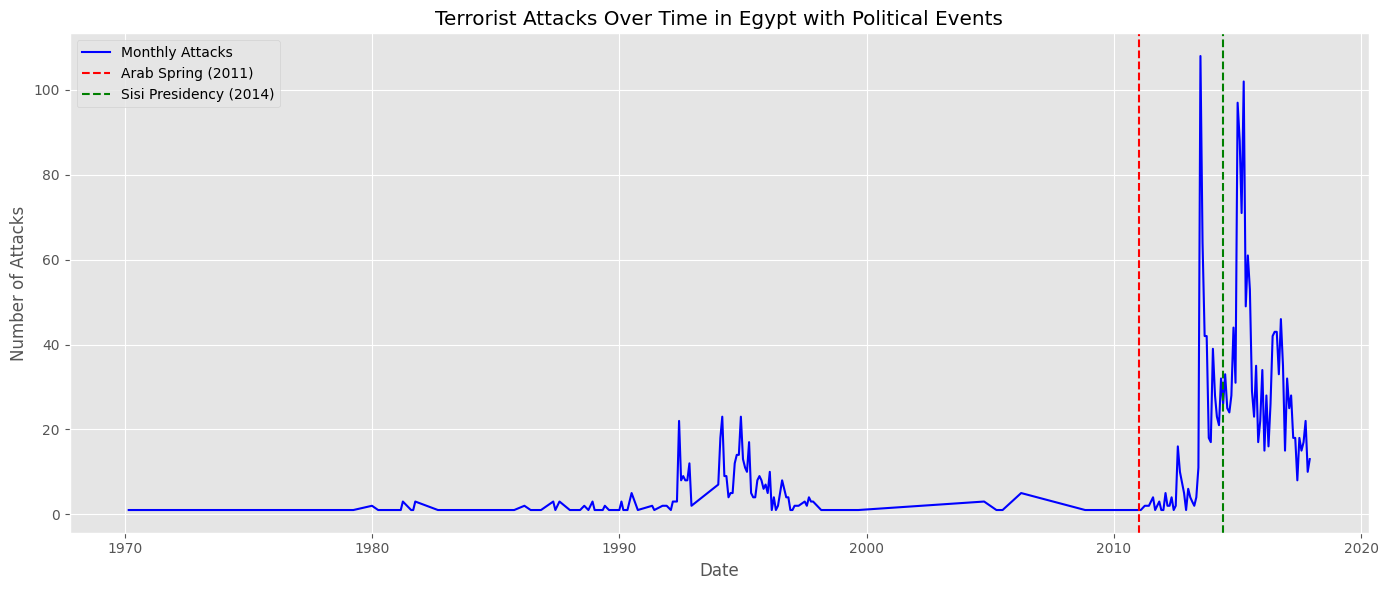

In [ ]:
# 📊 Plot the time series with intervention lines
plt.figure(figsize=(14, 6))
plt.plot(monthly_df['month'], monthly_df['attacks'], label='Monthly Attacks', color='blue')
plt.axvline(arab_spring, color='red', linestyle='--', label='Arab Spring (2011)')
plt.axvline(sisi_presidency, color='green', linestyle='--', label='Sisi Presidency (2014)')
plt.title('Terrorist Attacks Over Time in Egypt with Political Events')
plt.xlabel('Date')
plt.ylabel('Number of Attacks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Available columns: ['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country', 'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude', 'longitude', 'specificity', 'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple', 'success', 'suicide', 'attacktype1', 'attacktype1_txt', 'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt', 'target1', 'natlty1', 'natlty1_txt', 'gname', 'guncertain1', 'individual', 'weaptype1', 'weaptype1_txt', 'nkill', 'property', 'ishostkid', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY', 'date', 'inflation_rate']
No inflation column found. Creating a dummy column.
=== Attacks Model with Inflation ===
                            OLS Regression Results                            
Dep. Variable:                attacks   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     49.65
Date:

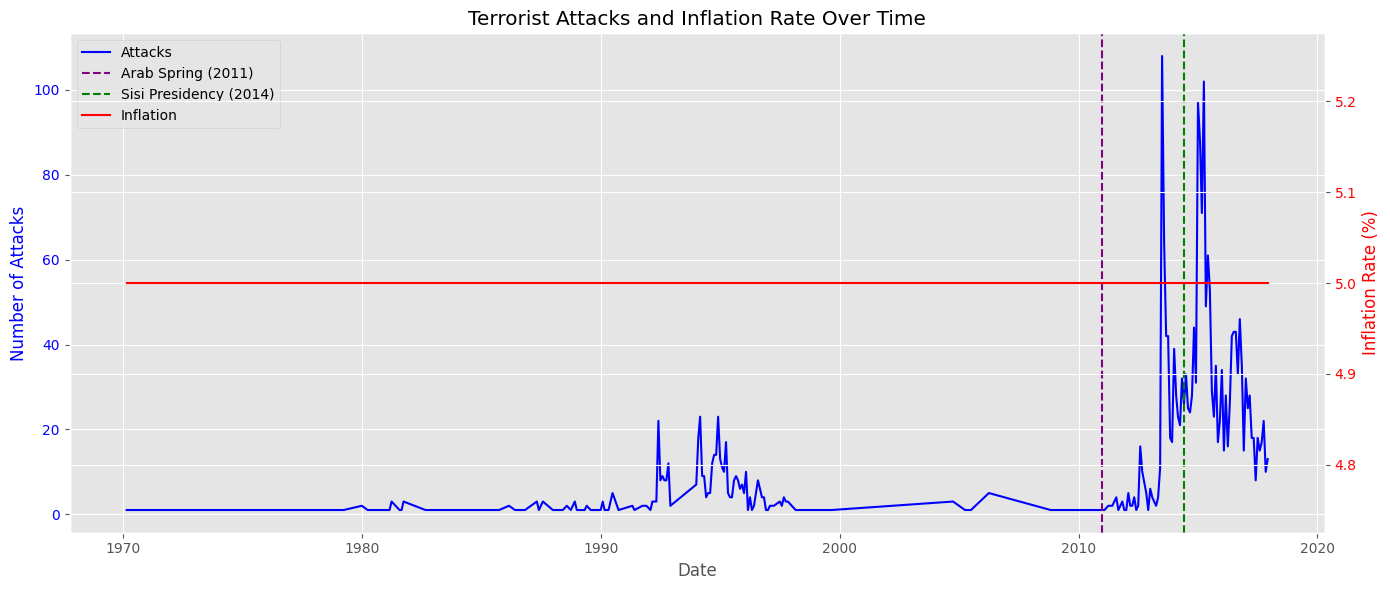

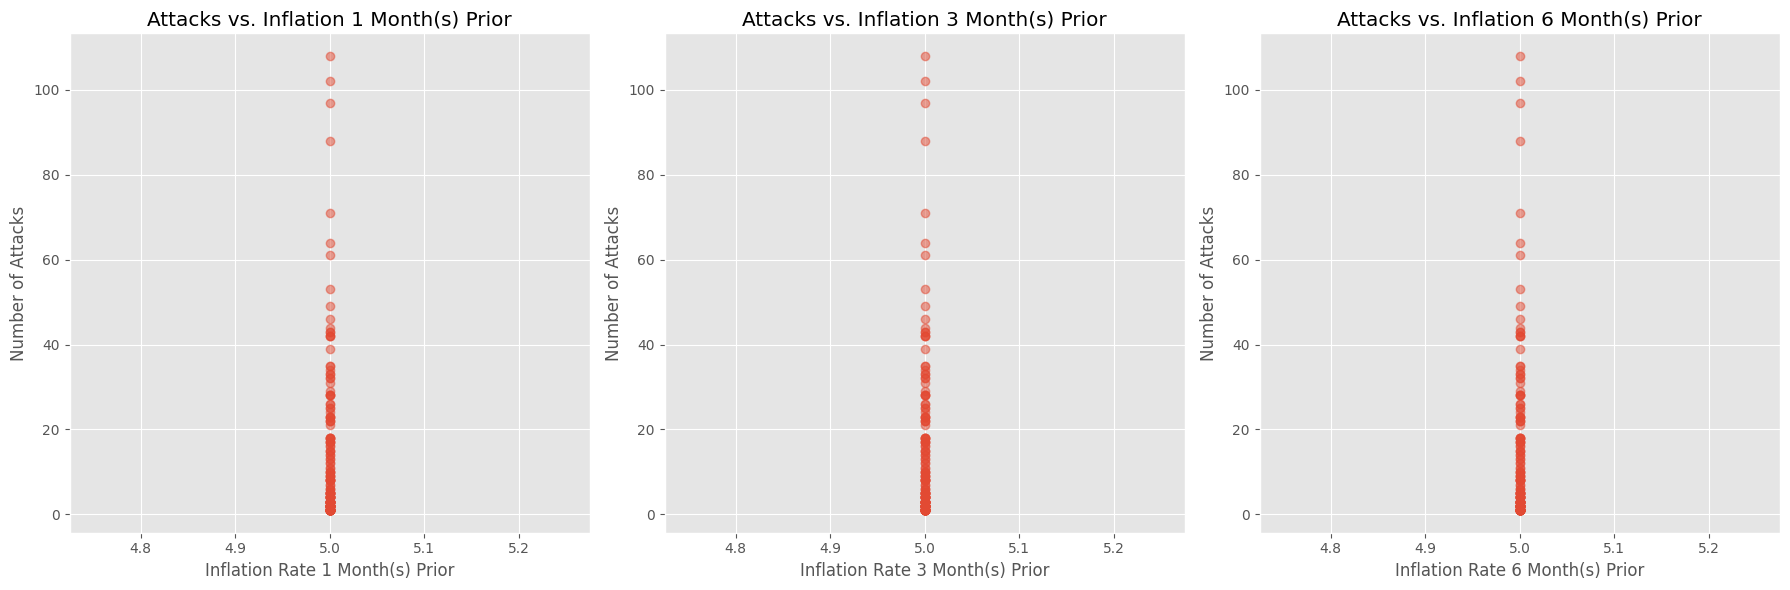

In [ ]:
# Display options
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# Load the dataset
df = pd.read_csv("Egypt_terr_augmented_with_infilation.csv")
# Check column names to find the inflation column
print("Available columns:", df.columns.tolist())

# Try to find the inflation column (it might be spelled as 'infilation')
inflation_column = 'infilation' if 'infilation' in df.columns else None

if not inflation_column:
    # If no inflation column found, create a dummy one for the code to run
    print("No inflation column found. Creating a dummy column.")
    df['infilation'] = 5.0  # Default value
    inflation_column = 'infilation'
else:
    print(f"Using inflation column: {inflation_column}")

# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')

# Create monthly time series of attacks and fatalities
monthly_df = df.groupby('month').agg({
    'eventid': 'count',
    'nkill': 'sum'
}).rename(columns={'eventid': 'attacks'}).reset_index()

# Convert month back to datetime
monthly_df['month'] = monthly_df['month'].dt.to_timestamp()

# Define key interruption dates
arab_spring = pd.to_datetime('2011-01-01')
sisi_presidency = pd.to_datetime('2014-06-01')

# Create time and intervention variables
monthly_df['time'] = np.arange(len(monthly_df))
monthly_df['post_arab_spring'] = (monthly_df['month'] >= arab_spring).astype(int)
monthly_df['post_sisi'] = (monthly_df['month'] >= sisi_presidency).astype(int)
monthly_df['time_post_arab_spring'] = monthly_df['time'] * monthly_df['post_arab_spring']
monthly_df['time_post_sisi'] = monthly_df['time'] * monthly_df['post_sisi']

# Add inflation to the monthly data
monthly_inflation = df.groupby('month')[inflation_column].mean().reset_index()
monthly_inflation['month'] = monthly_inflation['month'].dt.to_timestamp()

# Merge with existing monthly_df
monthly_df = monthly_df.merge(monthly_inflation, on='month', how='left')

# Rename the column to 'inflation' for consistency in the rest of the code
monthly_df = monthly_df.rename(columns={inflation_column: 'inflation'})

# Create models with inflation as covariate
def fit_itsa_model_with_inflation(outcome):
    X = monthly_df[[
        'time',
        'post_arab_spring', 'time_post_arab_spring',
        'post_sisi', 'time_post_sisi',
        'inflation'
    ]]
    X = sm.add_constant(X)
    y = monthly_df[outcome]
    model = sm.OLS(y, X).fit()
    return model

# Fit models with inflation
model_attacks_inflation = fit_itsa_model_with_inflation('attacks')
model_fatalities_inflation = fit_itsa_model_with_inflation('nkill')

# Display summaries
print("=== Attacks Model with Inflation ===")
print(model_attacks_inflation.summary())
print("\n=== Fatalities Model with Inflation ===")
print(model_fatalities_inflation.summary())

# GRAPH 1: Time series with dual y-axes showing attacks and inflation over time
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

# Plot attacks on primary y-axis
ax1.plot(monthly_df['month'], monthly_df['attacks'], 'b-', label='Attacks')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Attacks', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot inflation on secondary y-axis
ax2.plot(monthly_df['month'], monthly_df['inflation'], 'r-', label='Inflation')
ax2.set_ylabel('Inflation Rate (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add vertical lines for key events
ax1.axvline(arab_spring, color='purple', linestyle='--', label='Arab Spring (2011)')
ax1.axvline(sisi_presidency, color='green', linestyle='--', label='Sisi Presidency (2014)')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Terrorist Attacks and Inflation Rate Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# GRAPH 2: Lag analysis - does inflation predict attacks in future months?
# Create lagged inflation variables
for lag in [1, 3, 6]:
    monthly_df[f'inflation_lag_{lag}'] = monthly_df['inflation'].shift(lag)

# Drop rows with NaN from lagging
lagged_df = monthly_df.dropna()

# Create a multi-panel figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot each lag relationship
for i, lag in enumerate([1, 3, 6]):
    sns.regplot(x=f'inflation_lag_{lag}', y='attacks', data=lagged_df,
                ax=axes[i], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    axes[i].set_title(f'Attacks vs. Inflation {lag} Month(s) Prior')
    axes[i].set_xlabel(f'Inflation Rate {lag} Month(s) Prior')
    axes[i].set_ylabel('Number of Attacks')

plt.tight_layout()
plt.show()

# Save the figures
output_dir = "."  # Current directory, change if needed
fig.savefig(os.path.join(output_dir, "Terrorist_Attacks_and_Inflation_Over_Time.png"))

#Hypothesis 2

In [ ]:
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# Load the dataset
#df = pd.read_csv('Egypt_terr_augmented_with_infilation.csv')
df = pd.read_csv("../../Egypt_terr_augmented_with_infilation.csv")

In [ ]:
# Cell 3: Convert date and create time period columns
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')
df['year'] = df['date'].dt.year

In [ ]:
# Cell 4: Check available columns
print("Available columns:", df.columns.tolist())

Available columns: ['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country', 'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude', 'longitude', 'specificity', 'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple', 'success', 'suicide', 'attacktype1', 'attacktype1_txt', 'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt', 'target1', 'natlty1', 'natlty1_txt', 'gname', 'guncertain1', 'individual', 'weaptype1', 'weaptype1_txt', 'nkill', 'property', 'ishostkid', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY', 'date', 'inflation_rate', 'month', 'year']


In [ ]:
# Cell 5: Identify inflation column
# Based on your output, the column is named 'inflation_rate'
inflation_column = 'inflation_rate'

print(f"Using inflation column: {inflation_column}")

# Create monthly aggregation of terrorism metrics
monthly_df = df.groupby('month').agg({
    'eventid': 'count',
    'nkill': 'sum',
    inflation_column: 'mean'
}).rename(columns={'eventid': 'attacks'}).reset_index()

monthly_df['month'] = monthly_df['month'].dt.to_timestamp()

# Create annual aggregation for Pearson correlation
yearly_df = df.groupby('year').agg({
    'eventid': 'count',
    'nkill': 'sum',
    inflation_column: 'mean'
}).rename(columns={'eventid': 'attacks'}).reset_index()

# Rename the inflation column for consistency
monthly_df = monthly_df.rename(columns={inflation_column: 'inflation'})
yearly_df = yearly_df.rename(columns={inflation_column: 'inflation'})

Using inflation column: inflation_rate


In [ ]:
# Cell 6: Pearson correlation analysis (Hypothesis 4)
# 1. Correlation between inflation and attacks
corr_inflation_attacks, p_value_attacks = stats.pearsonr(yearly_df['inflation'], yearly_df['attacks'])

# 2. Correlation between inflation and fatalities
corr_inflation_fatalities, p_value_fatalities = stats.pearsonr(yearly_df['inflation'], yearly_df['nkill'])

# Print results
print("\n=== Hypothesis 4: Correlation between Inflation and Terrorism ===")
print(f"Correlation between inflation and attacks: {corr_inflation_attacks:.4f} (p-value: {p_value_attacks:.4f})")
print(f"Correlation between inflation and fatalities: {corr_inflation_fatalities:.4f} (p-value: {p_value_fatalities:.4f})")


=== Hypothesis 4: Correlation between Inflation and Terrorism ===
Correlation between inflation and attacks: 0.0511 (p-value: 0.7674)
Correlation between inflation and fatalities: 0.2257 (p-value: 0.1857)


In [ ]:
# Cell 7: Interpretation
alpha = 0.05
print("\nInterpretation:")

# For attacks
if p_value_attacks < alpha:
    if corr_inflation_attacks > 0:
        print("- There is a statistically significant POSITIVE correlation between inflation and number of attacks.")
    else:
        print("- There is a statistically significant NEGATIVE correlation between inflation and number of attacks.")

    # Interpret strength
    if abs(corr_inflation_attacks) < 0.3:
        print("  The correlation is weak.")
    elif abs(corr_inflation_attacks) < 0.7:
        print("  The correlation is moderate.")
    else:
        print("  The correlation is strong.")
else:
    print("- There is NO statistically significant correlation between inflation and number of attacks.")

# For fatalities
if p_value_fatalities < alpha:
    if corr_inflation_fatalities > 0:
        print("- There is a statistically significant POSITIVE correlation between inflation and fatalities.")
    else:
        print("- There is a statistically significant NEGATIVE correlation between inflation and fatalities.")

    # Interpret strength
    if abs(corr_inflation_fatalities) < 0.3:
        print("  The correlation is weak.")
    elif abs(corr_inflation_fatalities) < 0.7:
        print("  The correlation is moderate.")
    else:
        print("  The correlation is strong.")
else:
    print("- There is NO statistically significant correlation between inflation and fatalities.")


Interpretation:
- There is NO statistically significant correlation between inflation and number of attacks.
- There is NO statistically significant correlation between inflation and fatalities.


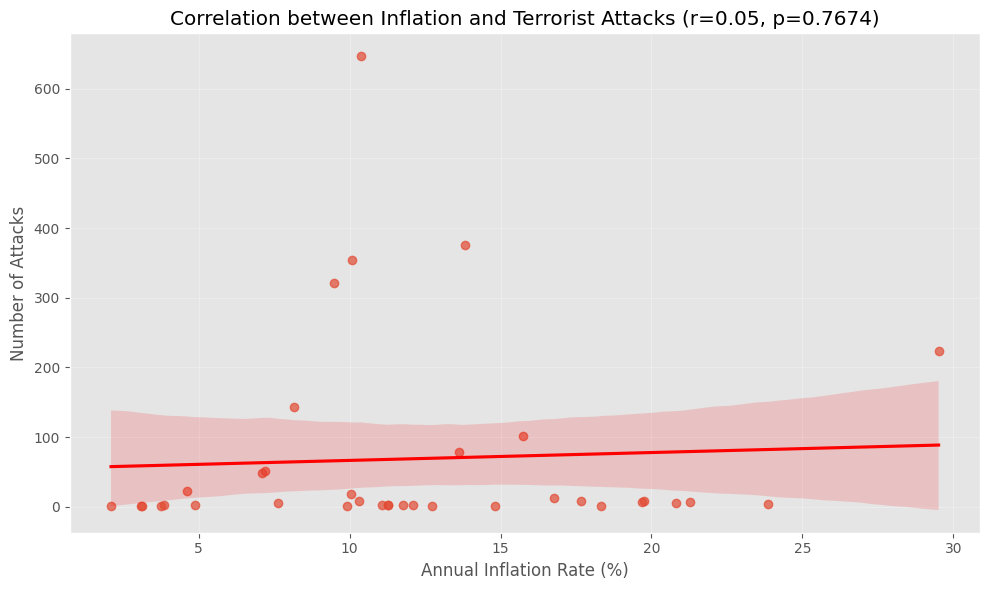

In [ ]:
# Cell 8: Scatter plot with regression line for yearly data (attacks)
plt.figure(figsize=(10, 6))
sns.regplot(x='inflation', y='attacks', data=yearly_df, scatter_kws={'alpha':0.7}, line_kws={'color':'red'})
plt.title(f'Correlation between Inflation and Terrorist Attacks (r={corr_inflation_attacks:.2f}, p={p_value_attacks:.4f})')
plt.xlabel('Annual Inflation Rate (%)')
plt.ylabel('Number of Attacks')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

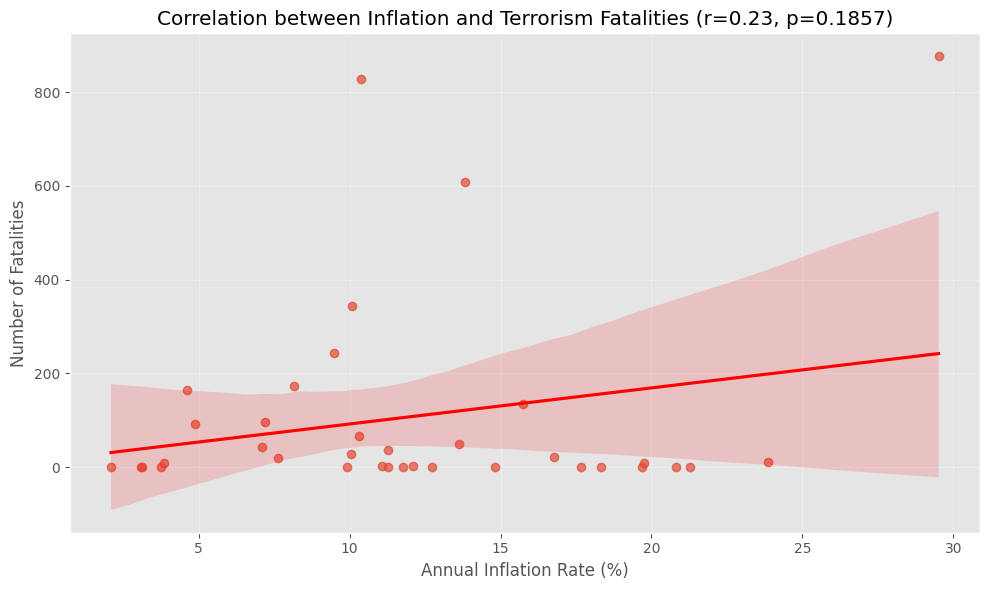

In [ ]:
# Cell 9: Scatter plot with regression line for yearly data (fatalities)
plt.figure(figsize=(10, 6))
sns.regplot(x='inflation', y='nkill', data=yearly_df, scatter_kws={'alpha':0.7}, line_kws={'color':'red'})
plt.title(f'Correlation between Inflation and Terrorism Fatalities (r={corr_inflation_fatalities:.2f}, p={p_value_fatalities:.4f})')
plt.xlabel('Annual Inflation Rate (%)')
plt.ylabel('Number of Fatalities')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

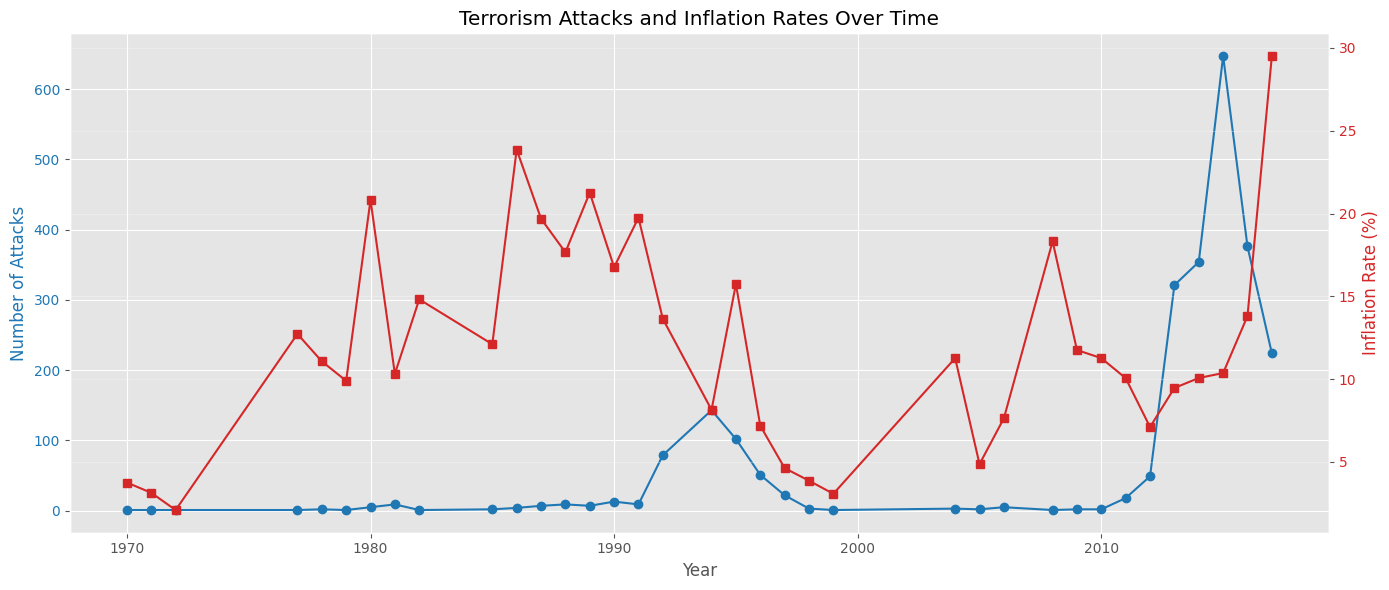

In [ ]:
# Cell 10: Time series plot showing both inflation and terrorism metrics
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Attacks', color=color)
ax1.plot(yearly_df['year'], yearly_df['attacks'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Inflation Rate (%)', color=color)
ax2.plot(yearly_df['year'], yearly_df['inflation'], color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Terrorism Attacks and Inflation Rates Over Time')
fig.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

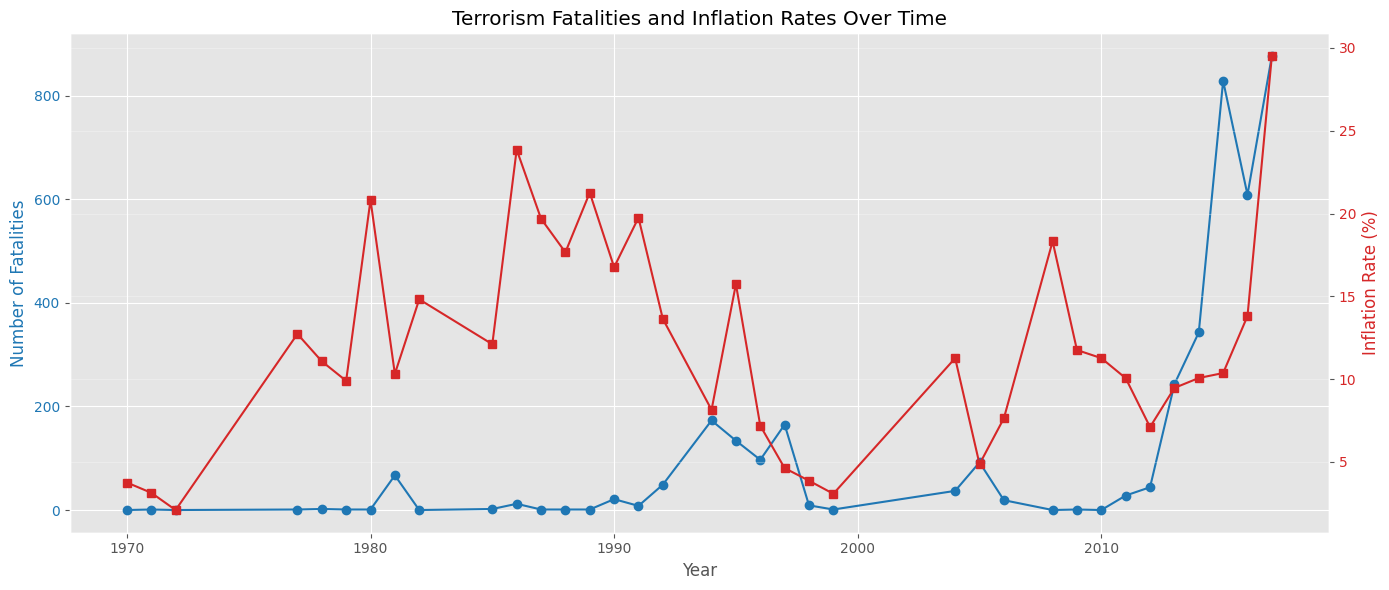

In [ ]:
# Cell 11: Time series plot showing both inflation and fatalities
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Fatalities', color=color)
ax1.plot(yearly_df['year'], yearly_df['nkill'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Inflation Rate (%)', color=color)
ax2.plot(yearly_df['year'], yearly_df['inflation'], color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Terrorism Fatalities and Inflation Rates Over Time')
fig.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

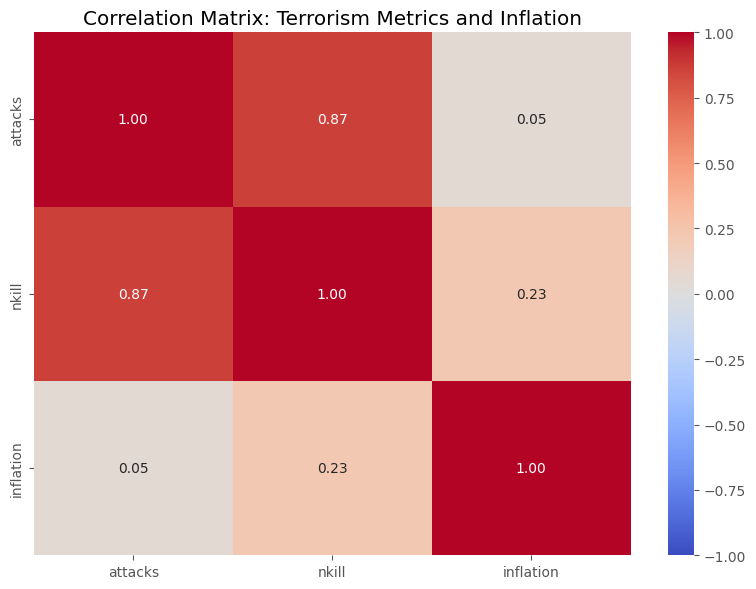

In [ ]:
# Cell 12: Heatmap of correlation matrix
correlation_vars = ['attacks', 'nkill', 'inflation']
correlation_matrix = yearly_df[correlation_vars].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix: Terrorism Metrics and Inflation')
plt.tight_layout()
plt.show()

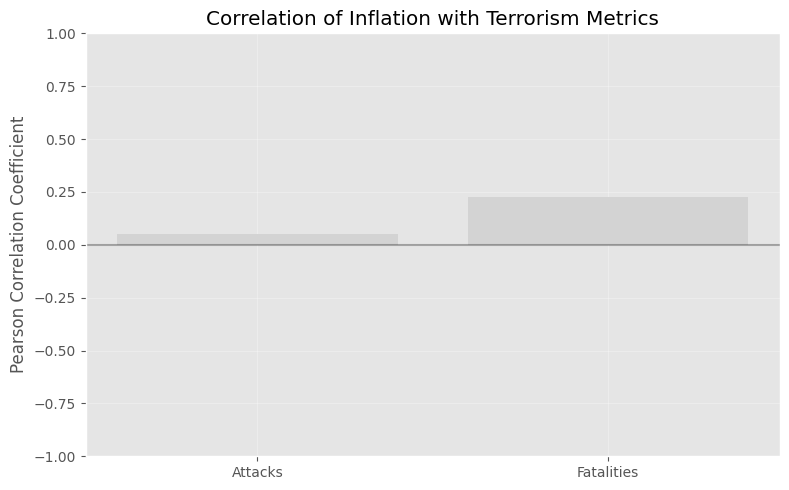

In [ ]:
# Cell 13: Bar chart showing correlation coefficients
plt.figure(figsize=(8, 5))
correlations = [corr_inflation_attacks, corr_inflation_fatalities]
labels = ['Attacks', 'Fatalities']
colors = ['blue' if p < 0.05 else 'lightgray' for p in [p_value_attacks, p_value_fatalities]]

bars = plt.bar(labels, correlations, color=colors)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.title('Correlation of Inflation with Terrorism Metrics')
plt.ylabel('Pearson Correlation Coefficient')
plt.ylim(-1, 1)

# Add significance indicators
for i, p in enumerate([p_value_attacks, p_value_fatalities]):
    if p < 0.001:
        plt.text(i, correlations[i] + 0.05, '***', ha='center')
    elif p < 0.01:
        plt.text(i, correlations[i] + 0.05, '**', ha='center')
    elif p < 0.05:
        plt.text(i, correlations[i] + 0.05, '*', ha='center')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Test 3 The frequency of terrorism incidents has significantly increased
over the studied period (1970-2017)

Trend: Increasing
h (hypothesis): True
p-value: 0.000127
z-value: 3.831878
Tau: 0.444444
s: 280.0
var_s: 5301.333333333333
slope: 1.000000
intercept: -11.500000


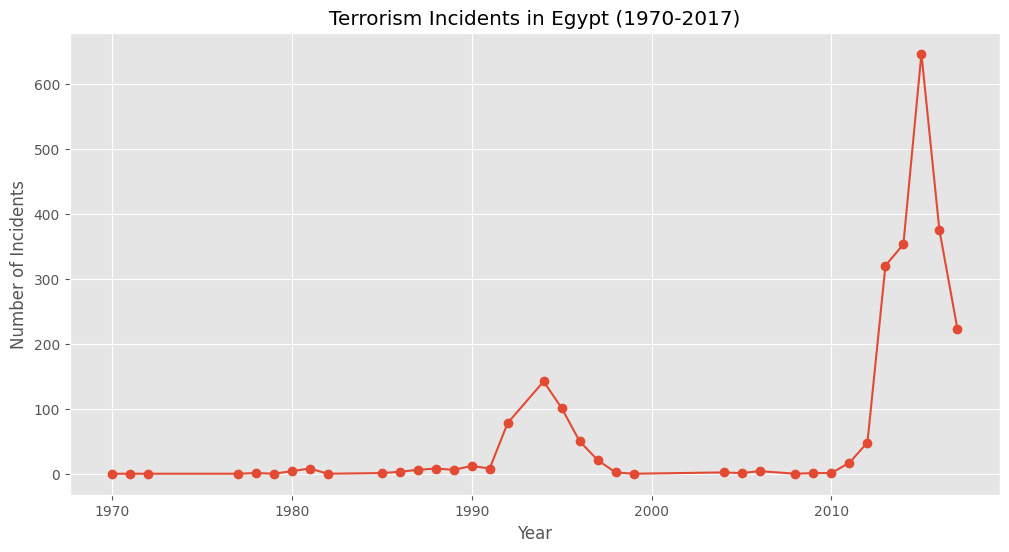

In [ ]:
# Test 3: Mann-Kendall Trend Test
result = mk.original_test(yearly_counts['incident_count'])
print(f"Trend: {'Increasing' if result.trend == 'increasing' else 'Decreasing' if result.trend == 'decreasing' else 'No trend'}")
print(f"h (hypothesis): {result.h}")
print(f"p-value: {result.p:.6f}")
print(f"z-value: {result.z:.6f}")
print(f"Tau: {result.Tau:.6f}")
print(f"s: {result.s}")
print(f"var_s: {result.var_s}")
print(f"slope: {result.slope:.6f}")
print(f"intercept: {result.intercept:.6f}")

# Visualize the trend
plt.figure(figsize=(12, 6))
plt.plot(yearly_counts['iyear'], yearly_counts['incident_count'], marker='o')
plt.title('Terrorism Incidents in Egypt (1970-2017)')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.savefig(os.path.join(output_dir, "Test_3.png"))
plt.show()
plt.close()

#Hypothesis 4

In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
def load_data():
    """
    Load and prepare the terrorism and inflation data
    """
    #df = pd.read_csv(file_path)
    df = pd.read_csv("../../Egypt_terr_augmented_with_infilation.csv")

    df['date'] = pd.to_datetime(df['date'])

    df['year'] = df['date'].dt.year

    return df

def aggregate_yearly_data(df):
    """
    Aggregate data by year to create time series
    """
    terrorism_by_year = df.groupby('year').size().reset_index(name='incident_count')

    inflation_by_year = df.groupby('year')['inflation_rate'].mean().reset_index()

    yearly_data = pd.merge(terrorism_by_year, inflation_by_year, on='year')

    return yearly_data

def calculate_time_lagged_correlation(data, max_lag=5):
    """
    Calculate time-lagged cross-correlation between inflation and terrorism incidents
    """
    inflation = data['inflation_rate'].values
    incidents = data['incident_count'].values

    correlation_results = ccf(inflation, incidents, adjusted=False)

    lags = np.arange(-max_lag, max_lag + 1)
    mid_point = len(correlation_results) // 2
    selected_correlations = correlation_results[mid_point - max_lag:mid_point + max_lag + 1]

    results_df = pd.DataFrame({
        'lag': lags,
        'correlation': selected_correlations
    })

    return results_df

def plot_time_lagged_correlation(correlation_df, title="Time-Lagged Cross-Correlation Analysis"):
    """
    Plot the time-lagged correlation results
    """
    plt.figure(figsize=(12, 6))

    plt.bar(correlation_df['lag'], correlation_df['correlation'], color='steelblue')

    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

    plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)

    plt.xlabel('Lag (Years)', fontsize=12)
    plt.ylabel('Correlation Coefficient', fontsize=12)
    plt.title(title, fontsize=14)

    plt.grid(True, alpha=0.3)

    # Add text explanation
    plt.figtext(0.5, 0.01,
                "Negative lag: Inflation precedes terrorism incidents\n"
                "Positive lag: Terrorism incidents precede inflation",
                ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    return plt

def plot_time_series(yearly_data):
    """
    Plot the time series of inflation rates and terrorism incidents
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Terrorism Incidents', color=color)
    ax1.plot(yearly_data['year'], yearly_data['incident_count'], color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Inflation Rate (%)', color=color)
    ax2.plot(yearly_data['year'], yearly_data['inflation_rate'], color=color, marker='s')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Terrorism Incidents and Inflation Rates Over Time')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, ['Terrorism Incidents', 'Inflation Rate'], loc='upper left')

    fig.tight_layout()
    return plt

In [ ]:
#file_name = next(iter(uploaded))
#print(f"Uploaded file: {file_name}")

df = load_data()

print("Data loaded successfully!")

print("\nFirst few rows of the dataset:")
df.head()

Data loaded successfully!

First few rows of the dataset:


,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,target1,natlty1,natlty1_txt,gname,guncertain1,individual,weaptype1,weaptype1_txt,nkill,property,ishostkid,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,date,inflation_rate,year
0,197003140002,1970,3,14,0,60,Egypt,10,Middle East & North Africa,Alexandria,Alexandria,31.198056,29.919167,1.0,0,1,1,1,0.0,0.0,1,0,3,Bombing/Explosion,6,Airports & Aircraft,42.0,Aircraft (not at an airport),United Arab Airlines Flight Antonov 24 Acft,60.0,Egypt,Unknown,0.0,0,6,Explosives,0.0,1,0.0,PGIS,-9,-9,0,-9,1970-03-14,3.76,1970
1,197111280001,1971,11,28,0,60,Egypt,10,Middle East & North Africa,Cairo,Cairo,30.084629,31.334314,1.0,0,1,1,1,0.0,0.0,1,0,1,Assassination,2,Government (General),17.0,Head of State,"Jordanian Prime Minister, Wasfi Tal",60.0,Egypt,Black September,0.0,0,5,Firearms,1.0,0,0.0,PGIS,1,1,0,1,1971-11-28,3.14,1971
2,197202190001,1972,2,19,0,60,Egypt,10,Middle East & North Africa,Cairo,Cairo,30.084629,31.334314,1.0,0,1,1,1,0.0,0.0,0,0,4,Hijacking,6,Airports & Aircraft,42.0,Aircraft (not at an airport),Caravelle,102.0,Jordan,Jordanian National Liberation Movement,0.0,0,6,Explosives,0.0,0,1.0,Hijacking DB,0,1,1,1,1972-02-19,2.10,1972
3,197712050001,1977,12,5,0,60,Egypt,10,Middle East & North Africa,Cairo,Cairo,30.084629,31.334314,1.0,0,1,1,1,0.0,0.0,1,0,1,Assassination,10,Journalists & Media,53.0,Newspaper Journalist/Staff/Facility,"David Holden, Chief of Foreign Correspondents",216.0,Great Britain,Unknown,0.0,0,5,Firearms,1.0,0,0.0,PGIS,-9,-9,1,1,1977-12-05,12.73,1977
4,197809300002,1978,9,30,0,60,Egypt,10,Middle East & North Africa,North Sinai,Yamit,31.275278,34.167778,1.0,1,1,1,1,-9.0,0.0,1,0,3,Bombing/Explosion,14,Private Citizens & Property,79.0,"Public Area (garden, parking lot, garage, beac...",beach at yamit,97.0,Israel,Palestinians,0.0,0,6,Explosives,0.0,1,0.0,PGIS,1,0,1,1,1978-09-30,11.08,1978


In [ ]:
yearly_data = aggregate_yearly_data(df)
print(f"Data aggregated for {len(yearly_data)} years")
yearly_data.head()

Data aggregated for 36 years


,year,incident_count,inflation_rate
0,1970,1,3.76
1,1971,1,3.14
2,1972,1,2.10
3,1977,1,12.73
4,1978,2,11.08


In [ ]:
print("Basic Statistics:")
print(f"Time period: {yearly_data['year'].min()} to {yearly_data['year'].max()}")
print(f"Total years: {len(yearly_data)}")
print(f"Total terrorism incidents: {yearly_data['incident_count'].sum()}")
print(f"Average yearly incidents: {yearly_data['incident_count'].mean():.2f}")
print(f"Average inflation rate: {yearly_data['inflation_rate'].mean():.2f}%")

Basic Statistics:
Time period: 1970 to 2017
Total years: 36
Total terrorism incidents: 2478
Average yearly incidents: 68.83
Average inflation rate: 11.99%


In [ ]:
max_lag = min(5, len(yearly_data) // 3)  # Set max lag to 5 or 1/3 of data length, whichever is smaller (the same thing)
correlation_df = calculate_time_lagged_correlation(yearly_data, max_lag=max_lag)

print("Time-Lagged Correlation Results:")
correlation_df

Time-Lagged Correlation Results:


,lag,correlation
0,-5,-0.029479
1,-4,-0.000245
2,-3,0.032217
3,-2,0.075977
4,-1,0.116635
5,0,0.130570
6,1,0.103452
7,2,0.055874
8,3,0.041964
9,4,0.022250


In [ ]:
max_corr_row = correlation_df.loc[correlation_df['correlation'].abs().idxmax()]
max_lag = max_corr_row['lag']
max_corr = max_corr_row['correlation']

print(f"Strongest correlation: {max_corr:.4f} at lag = {max_lag} years")

if max_lag < 0:
    print(f"This suggests that inflation rates may precede terrorism incidents by {abs(max_lag)} years.")
elif max_lag > 0:
    print(f"This suggests that terrorism incidents may precede inflation rates by {max_lag} years.")
else:
    print("This suggests that the strongest relationship is contemporaneous (same year).")

Strongest correlation: 0.1306 at lag = 0.0 years
This suggests that the strongest relationship is contemporaneous (same year).


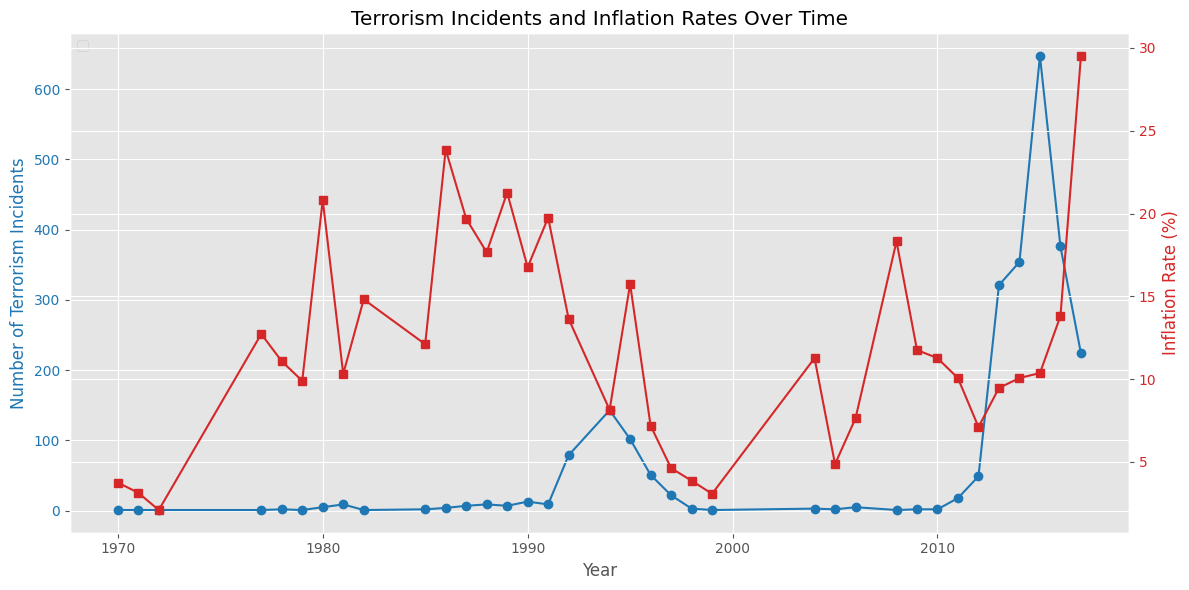

In [ ]:
plt_ts = plot_time_series(yearly_data)
plt.show()
plt.savefig(os.path.join(output_dir, "Test_4.png"))
plt.close()